# Constants

In [1]:
NUMBER_OF_PROCESSORS = 20
CLUSTERS_WIDTH = 2.0 # Default: 2.0
WATER_SIMULATION_IDS = [['B', 1, ' OW ']]
WATER_REFERENCE_IDS = [['B', 1, ' OW ']]
FIRST_ATOMS_TO_IGNORE = 1

# Imports

In [2]:
import os
from sklearn import cluster
import matplotlib.pyplot as plt
from matplotlib import patches

from scripts import obtain_water_data_from, get_reference_coords
from scripts import get_density, get_matchs, fulfill_condition
from scripts import write_centroids, get_metric, get_ordered_matchs
from scripts import add_matchs_to_reports

# Nonanol (NOL) in MUP at 8000K

In [3]:
SIMULATION_PATH = '/home/municoy/LocalResults/waters/1ZNK/8000K/'
try:
    # Create target Directory
    os.mkdir(SIMULATION_PATH + 'Plots')
except FileExistsError:
    pass

## Read Simulation data and extract water info

In [4]:
(atom_reports, atom_ids, atom_models, atom_coords), list_of_reports = \
    obtain_water_data_from(SIMULATION_PATH + 'adaptive.conf',
                           NUMBER_OF_PROCESSORS,
                           WATER_SIMULATION_IDS,
                           FIRST_ATOMS_TO_IGNORE)

- Parsing control file...
  - A total of 40 epochs and 5080 reports were found.
- Listing reports...
- Retrieving data...
- Linking report pointers...
- Parsing data...


## Retrieve reference data

In [5]:
ref_coords = get_reference_coords('1ZNK_original.pdb', SIMULATION_PATH + 'PDB', WATER_REFERENCE_IDS)

## Clustering

In [6]:
estimator = cluster.MeanShift(bandwidth=CLUSTERS_WIDTH, n_jobs=NUMBER_OF_PROCESSORS, cluster_all=True)
results = estimator.fit_predict(atom_coords)

In [7]:
reference_clusters = []
for ref_coord in ref_coords:
    reference_clusters += estimator.predict([ref_coord]).tolist()

## Clustering analysis

In [8]:
densities = get_density(atom_ids, results, WATER_SIMULATION_IDS)

In [9]:
# matchs_dict is dict will have atom_report + atom_model as key and number of matchs as value
matchs_dict = get_matchs(list_of_reports, results, atom_reports, atom_models, FIRST_ATOMS_TO_IGNORE)

## Display results

In [10]:
print('Ref', 'Cluster n.', 'Probability')
for cluster_n, cluster_density in densities.items():
    if (cluster_n in reference_clusters):
        print(' *    ', end='')
    else:
        print('      ', end='')
    print('{:3d}        {:5.3f}'.format(int(cluster_n), float(cluster_density)))

Ref Cluster n. Probability
        0        0.285
 *      1        0.208
        2        0.135
        3        0.098
        4        0.058
        5        0.068
        6        0.064
        7        0.040
        8        0.022
        9        0.014
       10        0.004
       11        0.001
       12        0.001
       13        0.001
       14        0.000
       15        0.001
       16        0.000


In [11]:
write_centroids(estimator, densities, SIMULATION_PATH + 'PDB/NOL_8000K_centroids.pdb', normalize=False)

In [12]:
energies = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='Binding Energy')
currentEnergy = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='currentEnergy')
water_energies = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='waterBEnergy')
rmsds = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='rmsd')
sum_of_energies = [i + j for i, j in zip(energies, water_energies)]
distances = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='Lig-Phe38_distance')
matchs = get_ordered_matchs(list_of_reports, matchs_dict, reference_clusters, FIRST_ATOMS_TO_IGNORE)
add_matchs_to_reports(list_of_reports, matchs, FIRST_ATOMS_TO_IGNORE)
norm = plt.Normalize(0, len(WATER_REFERENCE_IDS))
cmap = plt.cm.RdYlGn
patches_list = [patches.Patch(color=cmap(norm(0)), label='No matches'), ]
for i in range(len(WATER_REFERENCE_IDS)):
    if i == 0:
        match_str = "match"
    else:
        match_str = "matches"
    patches_list.append(patches.Patch(color=cmap(norm(i + 1)), label='{} {}'.format(i + 1, match_str)))

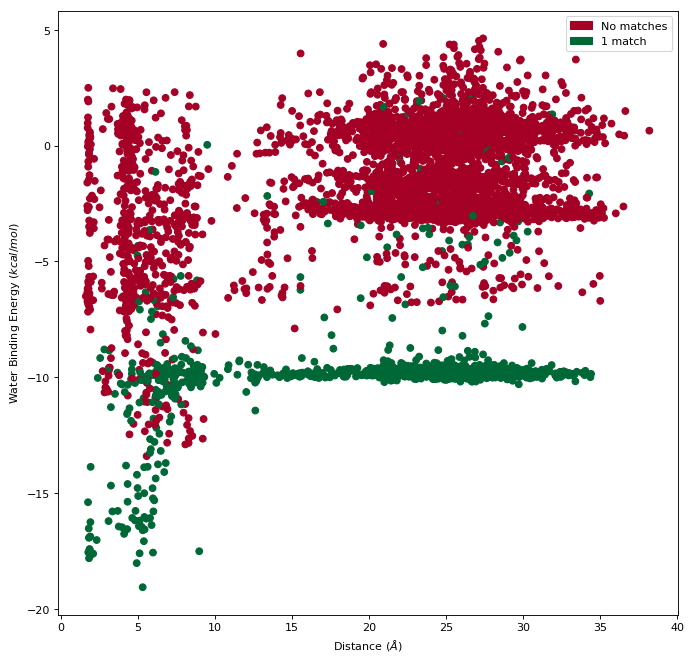

In [13]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Water Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, water_energies, c=matchs, cmap=cmap, norm=norm)
ax.legend(handles=patches_list)
plt.savefig(SIMULATION_PATH + 'Plots/8000K_WBE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

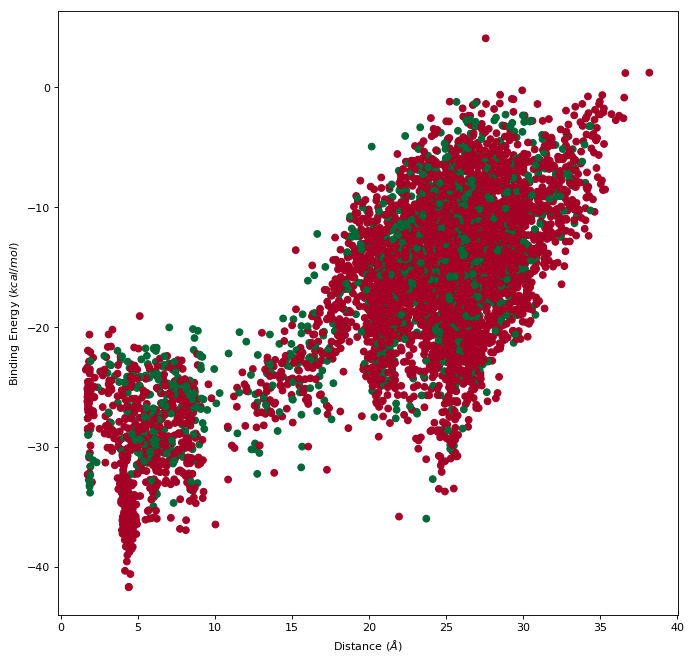

In [14]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, energies, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/8000K_BE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

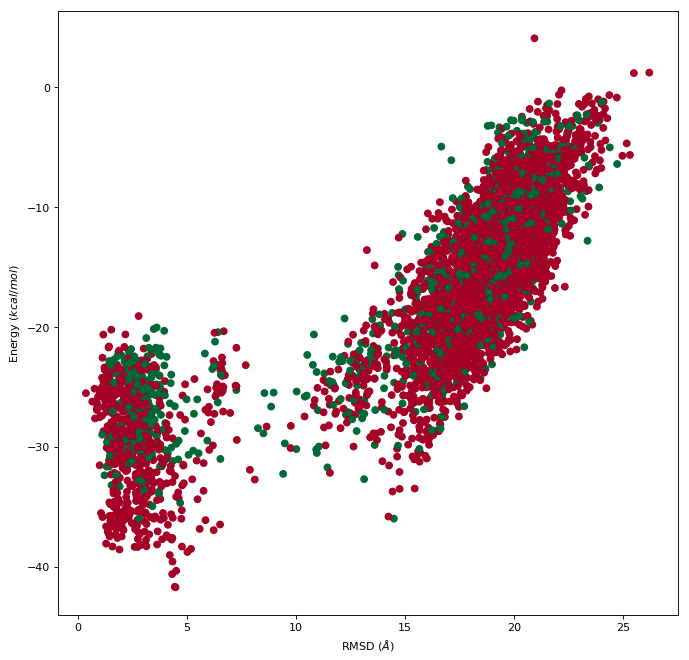

In [15]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('RMSD (' + r'$\AA$' + ')')
sc = ax.scatter(rmsds, energies, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/8000K_BE_RMSD.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

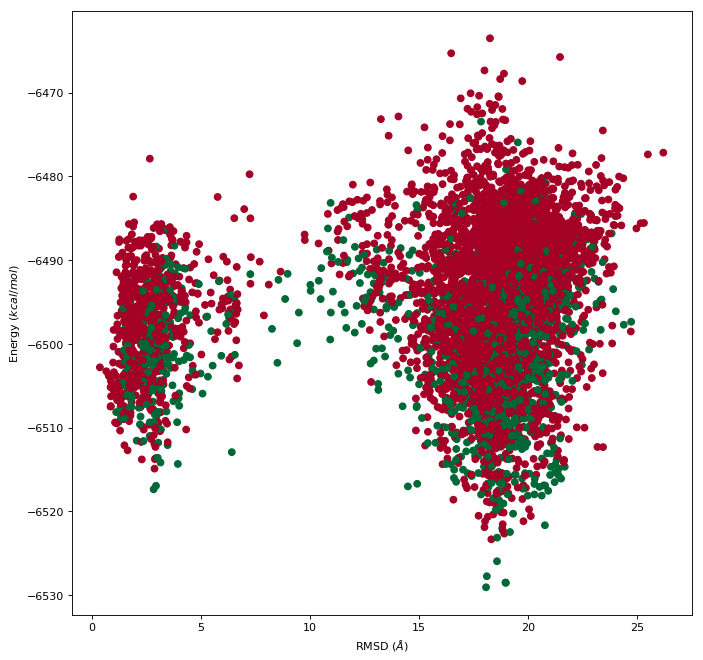

In [16]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('RMSD (' + r'$\AA$' + ')')
sc = ax.scatter(rmsds, currentEnergy, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/8000K_TE_RMSD.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

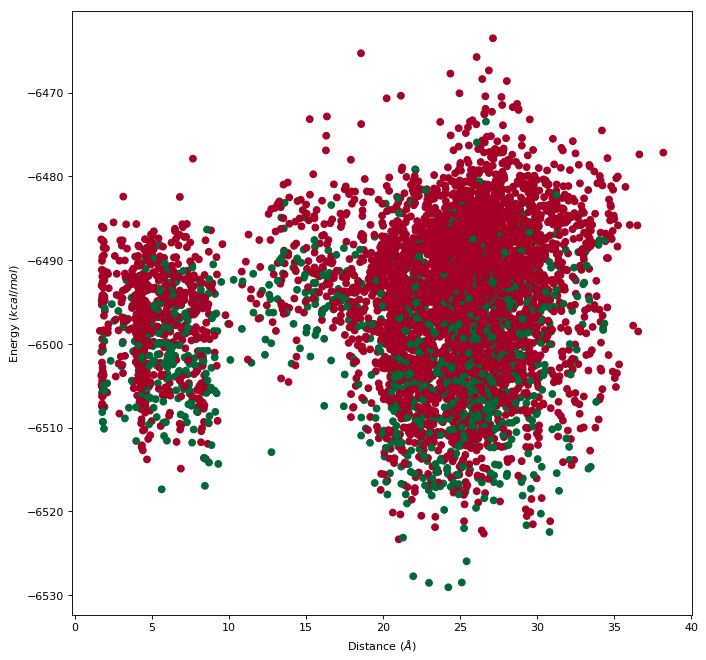

In [17]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, currentEnergy, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/8000K_TE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

In [18]:
#ax = sns.scatterplot(log_densities, list(energy1.values()))
#plt.show()

In [19]:
#ax = sns.scatterplot(log_densities, list(energy2.values()))
#plt.show()

In [20]:
#ax = sns.scatterplot(log_densities, list(energy3.values()))
#plt.show()

# Nonanol (NOL) in MUP at 1000K

In [21]:
SIMULATION_PATH = '/home/municoy/LocalResults/waters/1ZNK/1000K/'
try:
    # Create target Directory
    os.mkdir(SIMULATION_PATH + 'Plots')
except FileExistsError:
    pass

## Read Simulation data and extract water info

In [22]:
(atom_reports, atom_ids, atom_models, atom_coords), list_of_reports = \
    obtain_water_data_from(SIMULATION_PATH + 'adaptive.conf',
                           NUMBER_OF_PROCESSORS,
                           WATER_SIMULATION_IDS,
                           FIRST_ATOMS_TO_IGNORE)

- Parsing control file...
  - A total of 40 epochs and 5080 reports were found.
- Listing reports...
- Retrieving data...
- Linking report pointers...
- Parsing data...


## Retrieve reference data

In [23]:
ref_coords = get_reference_coords('1ZNK_original.pdb', SIMULATION_PATH + 'PDB', WATER_REFERENCE_IDS)

## Clustering

In [24]:
estimator = cluster.MeanShift(bandwidth=CLUSTERS_WIDTH, n_jobs=NUMBER_OF_PROCESSORS, cluster_all=True)
results = estimator.fit_predict(atom_coords)

In [25]:
reference_clusters = []
for ref_coord in ref_coords:
    reference_clusters += estimator.predict([ref_coord]).tolist()

## Clustering analysis

In [26]:
densities = get_density(atom_ids, results, WATER_SIMULATION_IDS)

In [27]:
# matchs_dict is dict will have atom_report + atom_model as key and number of matchs as value
matchs_dict = get_matchs(list_of_reports, results, atom_reports, atom_models, FIRST_ATOMS_TO_IGNORE)

## Display results

In [28]:
print('Ref', 'Cluster n.', 'Probability')
for cluster_n, cluster_density in densities.items():
    if (cluster_n in reference_clusters):
        print(' *    ', end='')
    else:
        print('      ', end='')
    print('{:3d}        {:5.3f}'.format(int(cluster_n), float(cluster_density)))

Ref Cluster n. Probability
 *      0        0.446
        1        0.217
        2        0.100
        3        0.044
        4        0.041
        5        0.034
        6        0.035
        7        0.026
        8        0.024
        9        0.016
       10        0.007
       11        0.007
       12        0.001
       13        0.001
       14        0.000


In [29]:
write_centroids(estimator, densities, SIMULATION_PATH + 'PDB/NOL_8000K_centroids.pdb', normalize=False)

In [30]:
energies = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='Binding Energy')
currentEnergy = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='currentEnergy')
water_energies = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='waterBEnergy')
rmsds = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='rmsd')
sum_of_energies = [i + j for i, j in zip(energies, water_energies)]
distances = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='Lig-Phe38_distance')
matchs = get_ordered_matchs(list_of_reports, matchs_dict, reference_clusters, FIRST_ATOMS_TO_IGNORE)
add_matchs_to_reports(list_of_reports, matchs, FIRST_ATOMS_TO_IGNORE)
norm = plt.Normalize(0, len(WATER_REFERENCE_IDS))
cmap = plt.cm.RdYlGn
patches_list = [patches.Patch(color=cmap(norm(0)), label='No matches'), ]
for i in range(len(WATER_REFERENCE_IDS)):
    if i == 0:
        match_str = "match"
    else:
        match_str = "matches"
    patches_list.append(patches.Patch(color=cmap(norm(i + 1)), label='{} {}'.format(i + 1, match_str)))

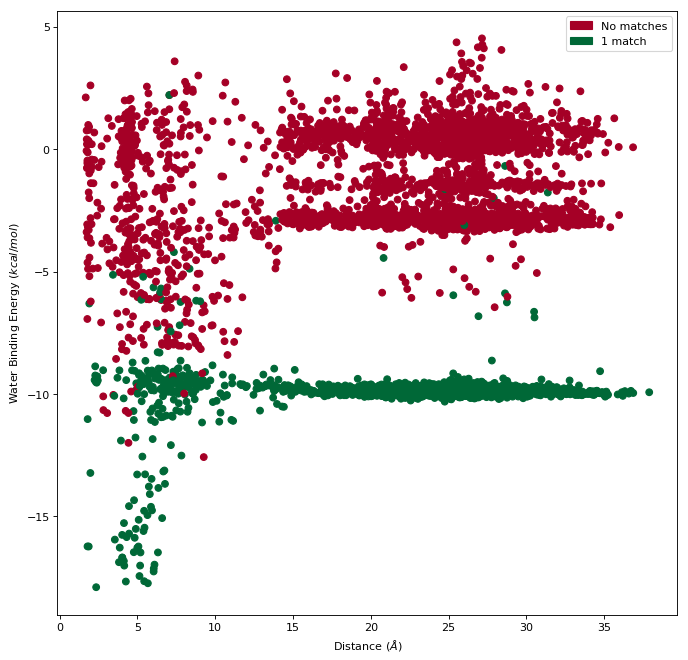

In [31]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Water Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, water_energies, c=matchs, cmap=cmap, norm=norm)
ax.legend(handles=patches_list)
plt.savefig(SIMULATION_PATH + 'Plots/1000K_WBE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

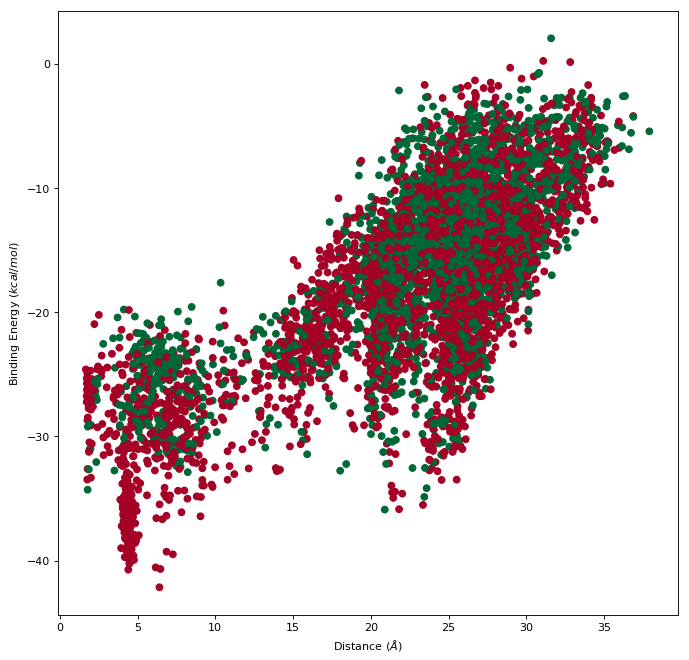

In [32]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, energies, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/1000K_BE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

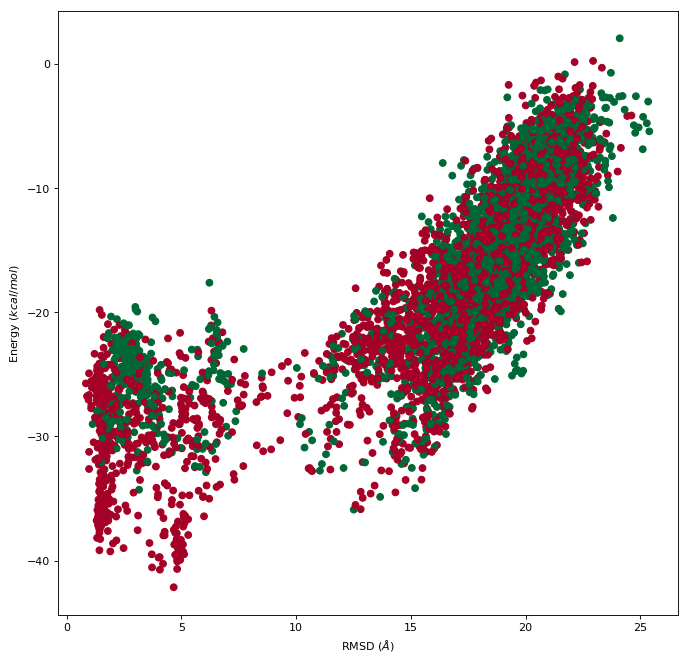

In [33]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('RMSD (' + r'$\AA$' + ')')
sc = ax.scatter(rmsds, energies, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/1000K_BE_RMSD.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

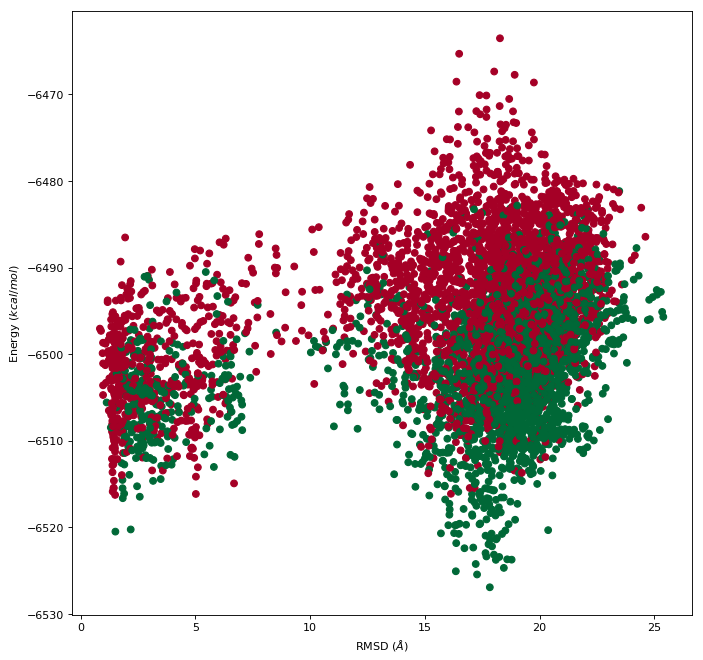

In [34]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('RMSD (' + r'$\AA$' + ')')
sc = ax.scatter(rmsds, currentEnergy, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/1000K_TE_RMSD.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

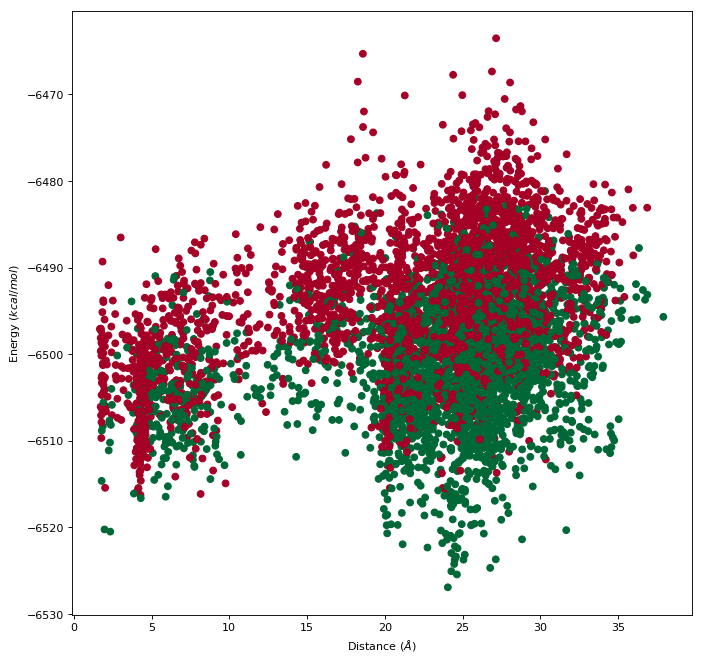

In [35]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, currentEnergy, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/1000K_TE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

# Nonanol (NOL) in MUP at 500K

In [36]:
SIMULATION_PATH = '/home/municoy/LocalResults/waters/1ZNK/500K/'
try:
    # Create target Directory
    os.mkdir(SIMULATION_PATH + 'Plots')
except FileExistsError:
    pass

## Read Simulation data and extract water info

In [37]:
(atom_reports, atom_ids, atom_models, atom_coords), list_of_reports = \
    obtain_water_data_from(SIMULATION_PATH + 'adaptive.conf',
                           NUMBER_OF_PROCESSORS,
                           WATER_SIMULATION_IDS,
                           FIRST_ATOMS_TO_IGNORE)

- Parsing control file...
  - A total of 40 epochs and 5080 reports were found.
- Listing reports...
- Retrieving data...
- Linking report pointers...
- Parsing data...


## Retrieve reference data

In [38]:
ref_coords = get_reference_coords('1ZNK_original.pdb', SIMULATION_PATH + 'PDB', WATER_REFERENCE_IDS)

## Clustering

In [39]:
estimator = cluster.MeanShift(bandwidth=CLUSTERS_WIDTH, n_jobs=NUMBER_OF_PROCESSORS, cluster_all=True)
results = estimator.fit_predict(atom_coords)

In [40]:
reference_clusters = []
for ref_coord in ref_coords:
    reference_clusters += estimator.predict([ref_coord]).tolist()

## Clustering analysis

In [41]:
densities = get_density(atom_ids, results, WATER_SIMULATION_IDS)

In [42]:
# matchs_dict is dict will have atom_report + atom_model as key and number of matchs as value
matchs_dict = get_matchs(list_of_reports, results, atom_reports, atom_models, FIRST_ATOMS_TO_IGNORE)

## Display results

In [43]:
print('Ref', 'Cluster n.', 'Probability')
for cluster_n, cluster_density in densities.items():
    if (cluster_n in reference_clusters):
        print(' *    ', end='')
    else:
        print('      ', end='')
    print('{:3d}        {:5.3f}'.format(int(cluster_n), float(cluster_density)))

Ref Cluster n. Probability
 *      0        0.477
        1        0.283
        2        0.109
        3        0.035
        4        0.030
        5        0.029
        6        0.023
        7        0.006
        8        0.005
        9        0.002
       10        0.001
       11        0.000
       12        0.000


In [44]:
write_centroids(estimator, densities, SIMULATION_PATH + 'PDB/NOL_8000K_centroids.pdb', normalize=False)

In [45]:
energies = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='Binding Energy')
currentEnergy = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='currentEnergy')
water_energies = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='waterBEnergy')
rmsds = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='rmsd')
sum_of_energies = [i + j for i, j in zip(energies, water_energies)]
distances = get_metric(list_of_reports, FIRST_ATOMS_TO_IGNORE, metric_name='Lig-Phe38_distance')
matchs = get_ordered_matchs(list_of_reports, matchs_dict, reference_clusters, FIRST_ATOMS_TO_IGNORE)
add_matchs_to_reports(list_of_reports, matchs, FIRST_ATOMS_TO_IGNORE)
norm = plt.Normalize(0, len(WATER_REFERENCE_IDS))
cmap = plt.cm.RdYlGn
patches_list = [patches.Patch(color=cmap(norm(0)), label='No matches'), ]
for i in range(len(WATER_REFERENCE_IDS)):
    if i == 0:
        match_str = "match"
    else:
        match_str = "matches"
    patches_list.append(patches.Patch(color=cmap(norm(i + 1)), label='{} {}'.format(i + 1, match_str)))

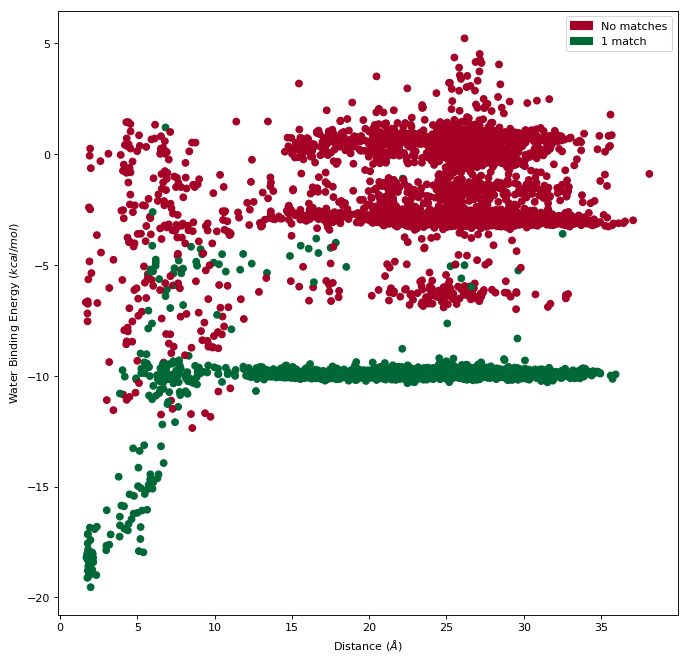

In [46]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Water Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, water_energies, c=matchs, cmap=cmap, norm=norm)
ax.legend(handles=patches_list)
plt.savefig(SIMULATION_PATH + 'Plots/500K_WBE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

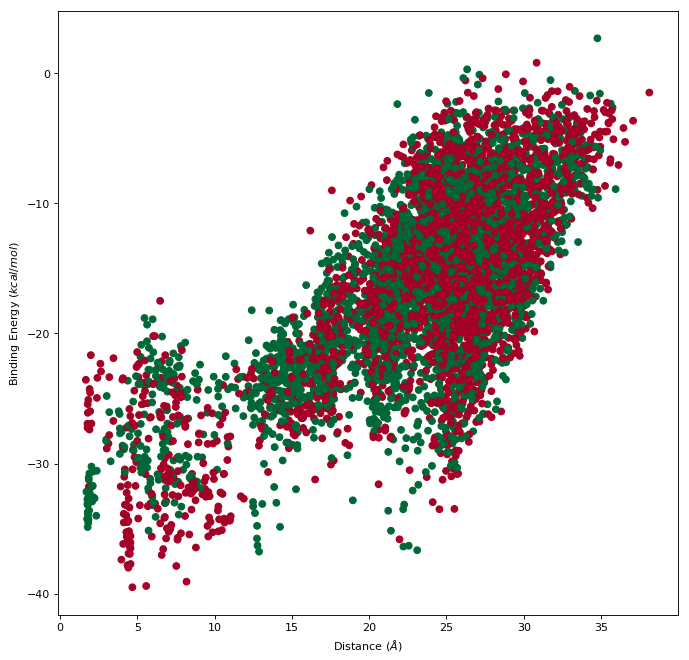

In [47]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Binding Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, energies, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/500K_BE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

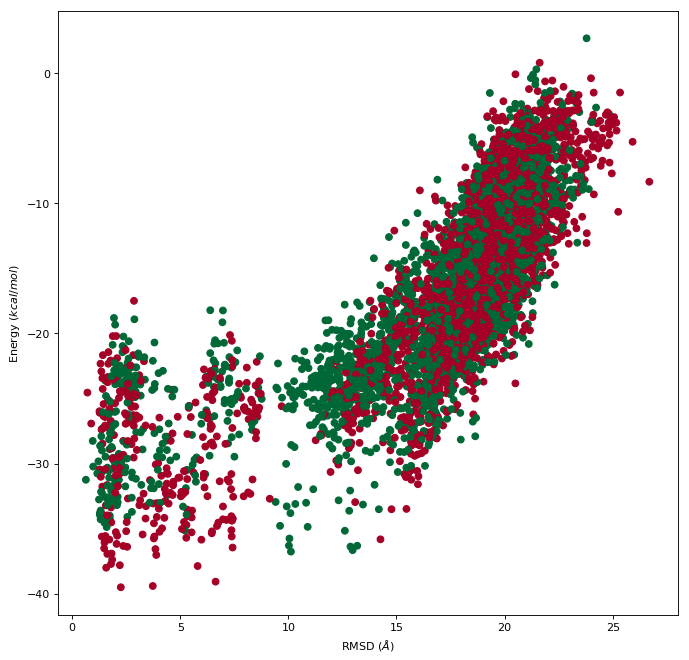

In [48]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('RMSD (' + r'$\AA$' + ')')
sc = ax.scatter(rmsds, energies, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/500K_BE_RMSD.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

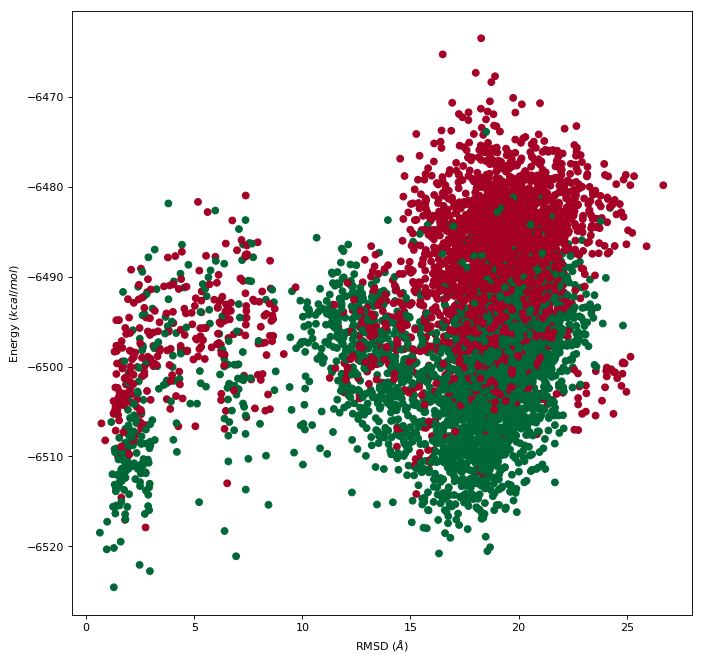

In [49]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('RMSD (' + r'$\AA$' + ')')
sc = ax.scatter(rmsds, currentEnergy, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/500K_TE_RMSD.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

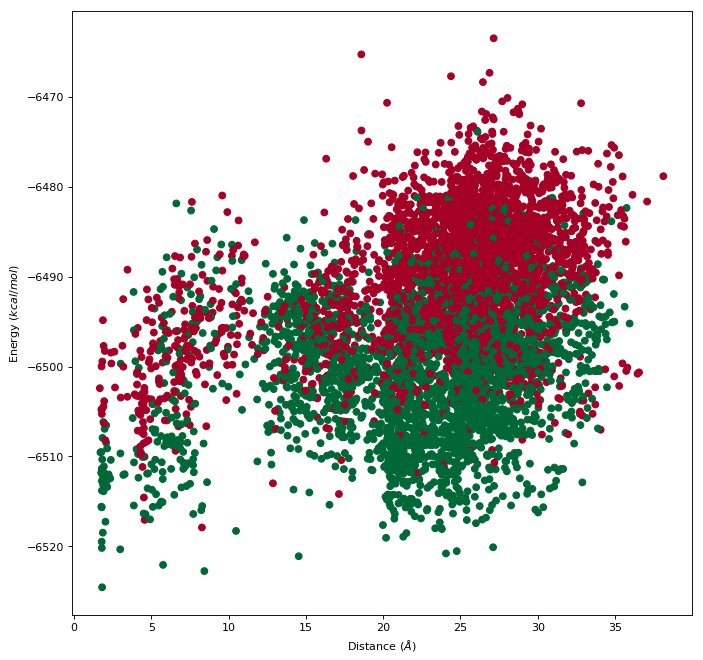

In [50]:
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.ylabel('Energy (' + r'$kcal/mol$' + ')')
plt.xlabel('Distance (' + r'$\AA$' + ')')
sc = ax.scatter(distances, currentEnergy, c=matchs, cmap=cmap, norm=norm)
plt.savefig(SIMULATION_PATH + 'Plots/500K_TE_D.png', dpi=80, facecolor='w',
            edgecolor='k', orientation='portrait', transparent=True)
plt.show()

# Nonanol (NOL) water exploration

## Read Simulation data and extract water info

In [51]:
SIMULATION_PATH = '/home/municoy/LocalResults/waters/1ZNK/WaterExploration/'

In [52]:
(atom_reports, atom_ids, atom_models, atom_coords), list_of_reports = \
    obtain_water_data_from(SIMULATION_PATH + 'pele.conf',
                           NUMBER_OF_PROCESSORS,
                           WATER_SIMULATION_IDS,
                           FIRST_ATOMS_TO_IGNORE)

- Parsing control file...
  - A total of 63 reports were found.
- Listing reports...
- Retrieving data...
- Linking report pointers...
- Parsing data...


## Clustering

In [53]:
estimator = cluster.MeanShift(bandwidth=CLUSTERS_WIDTH, n_jobs=NUMBER_OF_PROCESSORS, cluster_all=True)
results = estimator.fit_predict(atom_coords)

## Clustering analysis

In [54]:
densities = get_density(atom_ids, results, WATER_SIMULATION_IDS)

## Display results

In [55]:
print('Ref', 'Cluster n.', 'Probability')
for cluster_n, cluster_density in densities.items():
    if (cluster_n in reference_clusters):
        print(' *    ', end='')
    else:
        print('      ', end='')
    print('{:3d}        {:5.3f}'.format(int(cluster_n), float(cluster_density)))

Ref Cluster n. Probability
 *      0        0.378
        1        0.300
        2        0.073
        3        0.043
        4        0.052
        5        0.051
        6        0.037
        7        0.029
        8        0.021
        9        0.013
       10        0.002
       11        0.001


In [56]:
write_centroids(estimator, densities, SIMULATION_PATH + 'PDB/centroids.pdb', normalize=False)

# TODO
- Sampling seems insufficient. Try to run a long simulation at 1000K.
- Launch the same simulation without water to compare the results. (It should be less exploration around the binding site since the total energy should get worse there)

# Summary
- Water exploration is enhanced when setting low temperatures (500-1000K).